In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
import math

#경고 무시 & 폰트 설정
warnings.filterwarnings('ignore')
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 파일 경로 
base_path = 'open_track1/'

#데이터 로드
train_df = pd.read_csv(base_path + "train.csv")
test_df = pd.read_csv(base_path + "test.csv")
sample_submission = pd.read_csv(base_path + "sample_submission.csv")    
match_df = pd.read_csv(base_path + "match_info.csv")

# Excel 파일은 선택적으로 로드 (openpyxl 필요)
try:
    data_description = pd.read_excel(base_path + "data_description.xlsx")
    print("데이터 로딩 성공! (Excel 파일 포함)")
except Exception as e:
    print(f"Excel 파일 로딩 실패 (선택사항): {e}")
    print("CSV 파일들은 정상적으로 로드되었습니다.")
    data_description = None  # None으로 설정하여 나중에 체크 가능  

#데이터 모양 확인
print(f"Train: {train_df.shape} , Test: {test_df.shape}")      

데이터 로딩 성공! (Excel 파일 포함)
Train: (356721, 15) , Test: (2414, 3)


In [37]:
# Train DataFrame 정보
print("=" * 60)
print("📊 Train DataFrame 정보")
print("=" * 60)
print(f"Shape: {train_df.shape}")
print(f"Columns: {list(train_df.columns)}")
print(f"\nData Types:\n{train_df.dtypes}")
print(f"\n결측치:\n{train_df.isnull().sum()}")

# Test DataFrame 정보
print("\n" + "=" * 60)
print("📊 Test DataFrame 정보")
print("=" * 60)
print(f"Shape: {test_df.shape}")
print(f"Columns: {list(test_df.columns)}")
print(f"\nData Types:\n{test_df.dtypes}")

# Sample Submission 정보
print("\n" + "=" * 60)
print("📊 Sample Submission 정보")
print("=" * 60)
print(f"Shape: {sample_submission.shape}")
print(f"Columns: {list(sample_submission.columns)}")
print(f"\nData Types:\n{sample_submission.dtypes}")

# Match Info 정보
print("\n" + "=" * 60)
print("📊 Match Info 정보")
print("=" * 60)
print(f"Shape: {match_df.shape}")
print(f"Columns: {list(match_df.columns)}")
print(f"\nData Types:\n{match_df.dtypes}")

# Data Description 정보
print("\n" + "=" * 60)
if data_description is not None:
    print("📊 Data Description 정보")
    print("=" * 60)
    print(f"Shape: {data_description.shape}")
    print(f"Columns: {list(data_description.columns)}")
    print(f"\nData Types:\n{data_description.dtypes}")
else:
    print("⚠️ data_description은 로드되지 않았습니다 (Excel 파일 읽기 실패)")

📊 Train DataFrame 정보
Shape: (356721, 15)
Columns: ['game_id', 'period_id', 'episode_id', 'time_seconds', 'team_id', 'player_id', 'action_id', 'type_name', 'result_name', 'start_x', 'start_y', 'end_x', 'end_y', 'is_home', 'game_episode']

Data Types:
game_id           int64
period_id         int64
episode_id        int64
time_seconds    float64
team_id           int64
player_id         int64
action_id         int64
type_name        object
result_name      object
start_x         float64
start_y         float64
end_x           float64
end_y           float64
is_home            bool
game_episode     object
dtype: object

결측치:
game_id              0
period_id            0
episode_id           0
time_seconds         0
team_id              0
player_id            0
action_id            0
type_name            0
result_name     140254
start_x              0
start_y              0
end_x                0
end_y                0
is_home              0
game_episode         0
dtype: int64

📊 Test Data

In [38]:
#EDA & 데이터 전처리
train_df['is_train'] = 1
test_df['is_train'] = 0

#데이터 합치기(전처리 한번에)
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

#match와 병합(game_id 기준)
#match에 중보된 game_id가 없는지 확인 필요
match_df = match_df.drop_duplicates('game_id')
all_df = pd.merge(all_df, match_df, on='game_id', how='left')
print(f"병합 후 전체 크기: {all_df.shape}")

병합 후 전체 크기: (359135, 33)


In [39]:

#기하학적 파생변수 생성 함수
def add_geometry_features(df):
    df['dist_from_center'] = np.sqrt((df['start_x']-50)**2 + (df['start_y']-50)**2)
    df['dist_to_goal'] = np.sqrt((df['start_x'] - 100)**2 + (df['start_y']-50)**2)
    df['angle_from_origin'] = np.arctan2(df['start_y'], df['start_x'])

    return df
# 실제로 적용하기 (데이터 프레임에 컬럼 추가)
all_df = add_geometry_features(all_df)
  

#결측치 확인 및 채우기
all_df['start_x'] = all_df['start_x'].fillna(all_df['start_x'].mean())
all_df['start_y'] = all_df['start_y'].fillna(all_df['start_y'].mean())

print("결측치(NaN) 제거 완료! 이제 K-Means가 밥을 잘 먹을 겁니다.")

#모델생성(kmeans는 위치를 나누고 그위치마다 라벨링 이름을 붙여주는 것)
kmeans = KMeans(n_clusters=5, random_state=42)

#학습 및 예측( 위치를 보고 이름표 붙여라)
all_df['location_cluster'] = kmeans.fit_predict(all_df[['start_x', 'start_y']])

print("파생변수 완료(거리, 각도, 클러스터")

결측치(NaN) 제거 완료! 이제 K-Means가 밥을 잘 먹을 겁니다.
파생변수 완료(거리, 각도, 클러스터


In [40]:
#범주형 변수를 인코딩(팀이름,선수이름같은 글자로 된 데이터를 숫자로 변형)
cat_cols = ['team_id', 'player_id','result_name'] #result_name은 train에만 유의미할 수있다
#result_name은 성공/실패은 test에 없으므로 train인지 target인지 결정해야
#좌표예측이 목표임으로 여기서는 team_id,palyer_id만 인코딩합니다.

le = LabelEncoder()
for col in ['team_id', 'player_id']:
    all_df[col] = all_df[col].astype(str) #문자열로 통일
    all_df[col] = le.fit_transform(all_df[col])
    

In [41]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# 고급 파생변수 생성
# 선수별 패스 스타일(거리,각도 평균)
# 이선수는 평소에 길게 차나 짧게 차나?
def add_player_stats(train, test):
    #기존에 있는 중복컬럼 제거
    cols_to_remove = ['avg_p_dist_goal', 'avg_p_dist_center', 'avg_p_angle']
    train = train.drop(columns=cols_to_remove, errors='ignore')
    test = test.drop(columns=cols_to_remove, errors='ignore')

    #선수별 평균 계산
    player_stats = train.groupby('player_id')[['dist_to_goal', 'dist_from_center', 'angle_from_origin']].mean()
    player_stats.columns = ['avg_p_dist_goal', 'avg_p_dist_center', 'avg_p_angle']

    #인덱스를 컬럼으로 꺼내기
    player_stats = player_stats.reset_index()

    #train과 test에 추가
    train = pd.merge(train, player_stats, on='player_id', how='left')
    test = pd.merge(test, player_stats, on='player_id', how='left')
    
    #결측치 처리(전체 평균으로)
    for col in player_stats.columns:
        train[col] = train[col].fillna(train[col].mean())
        test[col] = test[col].fillna(test[col].mean())
    
    return train, test

# 경기 시간 (피로도) 변수(전반 5분패스와 40분의 패스는 다르다)
def add_time_features(df):
    #전반/후반 시간을 정규화(45분 단위 주기성)
    df['normalized_time'] = df['time_seconds'] % 2700
    return df

# all_df에서 train과 test 분리
train_final = all_df[all_df['is_train'] == 1].copy()
test_final = all_df[all_df['is_train'] == 0].copy()

#함수 적용
print("고급 파생변수 생성 중...")
train_final, test_final = add_player_stats(train_final, test_final)
train_final = add_time_features(train_final) 
test_final = add_time_features(test_final)
print("선수별 통계 & 시간 변수 추가 완료!") 


고급 파생변수 생성 중...
선수별 통계 & 시간 변수 추가 완료!


In [42]:
"""
#모델링(XGBoost)
# 'end_x','end_y' 두개의 값을 동시에 예측해야 함으로 MultiOutputRegressor를 사용
#학습에 사용할 변수 선정
features = ['start_x', 'start_y', 'dist_from_center', 'dist_to_goal', 'angle_from_origin', 
            'location_cluster', 'team_id', 'player_id']
#데이터 다시 나누기
train_final = all_df[all_df['is_train'] == 1]
test_final = all_df[all_df['is_train'] == 0]

X = train_final[features]
y = train_final[['end_x', 'end_y']]

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("모델 학습 시작... (XGBoost)")

#XGBoost 모델 설정
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, n_jobs=-1, random_state=42)

#다중 출력 래퍼 적용
model = MultiOutputRegressor(xgb)
model.fit(X_train, y_train)

#검증(RMSE)
val_pred = model.predict(X_val)

rmse_x = np.sqrt(mean_squared_error(y_val['end_x'], val_pred[:, 0]))
rmse_y = np.sqrt(mean_squared_error(y_val['end_y'], val_pred[:, 1]))

#rmse_x, rmse_y (채점하기)
total_rmse = (rmse_x + rmse_y)/2

print(f"검증 결과 RMSE - X: {rmse_x:.4f}, Y: {rmse_y:.4f}, Avg: {total_rmse:.4f}")
"""


'\n#모델링(XGBoost)\n# \'end_x\',\'end_y\' 두개의 값을 동시에 예측해야 함으로 MultiOutputRegressor를 사용\n#학습에 사용할 변수 선정\nfeatures = [\'start_x\', \'start_y\', \'dist_from_center\', \'dist_to_goal\', \'angle_from_origin\', \n            \'location_cluster\', \'team_id\', \'player_id\']\n#데이터 다시 나누기\ntrain_final = all_df[all_df[\'is_train\'] == 1]\ntest_final = all_df[all_df[\'is_train\'] == 0]\n\nX = train_final[features]\ny = train_final[[\'end_x\', \'end_y\']]\n\n# 학습/검증 데이터 분리\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\nprint("모델 학습 시작... (XGBoost)")\n\n#XGBoost 모델 설정\nxgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, n_jobs=-1, random_state=42)\n\n#다중 출력 래퍼 적용\nmodel = MultiOutputRegressor(xgb)\nmodel.fit(X_train, y_train)\n\n#검증(RMSE)\nval_pred = model.predict(X_val)\n\nrmse_x = np.sqrt(mean_squared_error(y_val[\'end_x\'], val_pred[:, 0]))\nrmse_y = np.sqrt(mean_squared_error(y_val[\'end_y\'], val_pred[:, 1]))\n\n#rmse_x, rmse_y (채점하기

In [43]:
# LightGBM 모델링
#학습에 사용할 변수들
features = [
    'start_x', 'start_y',    # 기본좌표
    'dist_from_center', 'dist_to_goal', 'angle_from_origin', #기하학적 변수
    'location_cluster', # 구역
    'avg_p_dist_goal', 'avg_p_dist_center', 'avg_p_angle', #선수 습관
    'player_id', 'team_id', #ID정보
    'normalized_time' # 피로도
]

X = train_final[features]
y = train_final[['end_x', 'end_y']]

#데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f" LightGBM 모델 학습 시작! (Features: {features}개)")


#LightGBM 설정(XGBoost보다 빠르고 범주형데이터에서는 강함)
lgbm = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate = 0.05,
    num_leaves = 63,  #나무의 복잡도
    n_jobs=-1,
    random_state=42
)

#다중 출력 래퍼 + LightGBM
model_lgbm = MultiOutputRegressor(lgbm)
model_lgbm.fit(X_train, y_train)


 LightGBM 모델 학습 시작! (Features: ['start_x', 'start_y', 'dist_from_center', 'dist_to_goal', 'angle_from_origin', 'location_cluster', 'avg_p_dist_goal', 'avg_p_dist_center', 'avg_p_angle', 'player_id', 'team_id', 'normalized_time']개)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 285376, number of used features: 12
[LightGBM] [Info] Start training from score 51.035869
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 285376, number of used features: 12
[LightG

MultiOutputRegressor(estimator=LGBMRegressor(learning_rate=0.05,
                                             n_estimators=500, n_jobs=-1,
                                             num_leaves=63, random_state=42))

In [44]:
# 검증 및 결과 확인
val_pred = model_lgbm.predict(X_val)

rmse_x = np.sqrt(mean_squared_error(y_val['end_x'], val_pred[:, 0]))
rmse_y = np.sqrt(mean_squared_error(y_val['end_y'], val_pred[:, 1]))
total_Rmse = (rmse_x + rmse_y)/2

print(f"\n 최종 성적표(LightGBM)")
print(f"RMSE - X: {rmse_x:.4f}m")
print(f"RMSE - Y: {rmse_y:.4f}m")
print(f"평균 오차: {total_rmse:.4f}m (이전보다 얼마나 줄었는지 확인하세요!)")

#제출 파일 생성
test_pred = model_lgbm.predict(test_final[features])
sample_submission['end_x'] = test_pred[:, 0]
sample_submission['end_y'] = test_pred[:, 1]
sample_submission.to_csv('submission_lgbm_final.csv', index=False)
print("최종 제출 파일 생성 완료: submissin_lgbm_final.csv")


 최종 성적표(LightGBM)
RMSE - X: 11.1922m
RMSE - Y: 10.7516m


NameError: name 'total_rmse' is not defined

In [ ]:
# 제출 파일 생성
test_pred = model_lgbm.predict(test_final[features])
sample_submission['end_x'] = test_pred[:, 0]
sample_submission['end_y'] = test_pred[:, 1]
sample_submission.to_csv('submission_lgbm_final.csv', index=False)
print("🎉 최종 제출 파일 생성 완료!")
print(sample_submission.head())

🎉 최종 제출 파일 생성 완료!
  game_episode      end_x     end_y
0     153363_1  47.356536  28.74964
1     153363_2  47.356536  28.74964
2     153363_6  47.356536  28.74964
3     153363_7  47.356536  28.74964
4     153363_8  47.356536  28.74964


k-league 패스 데이터 인사이트 분석


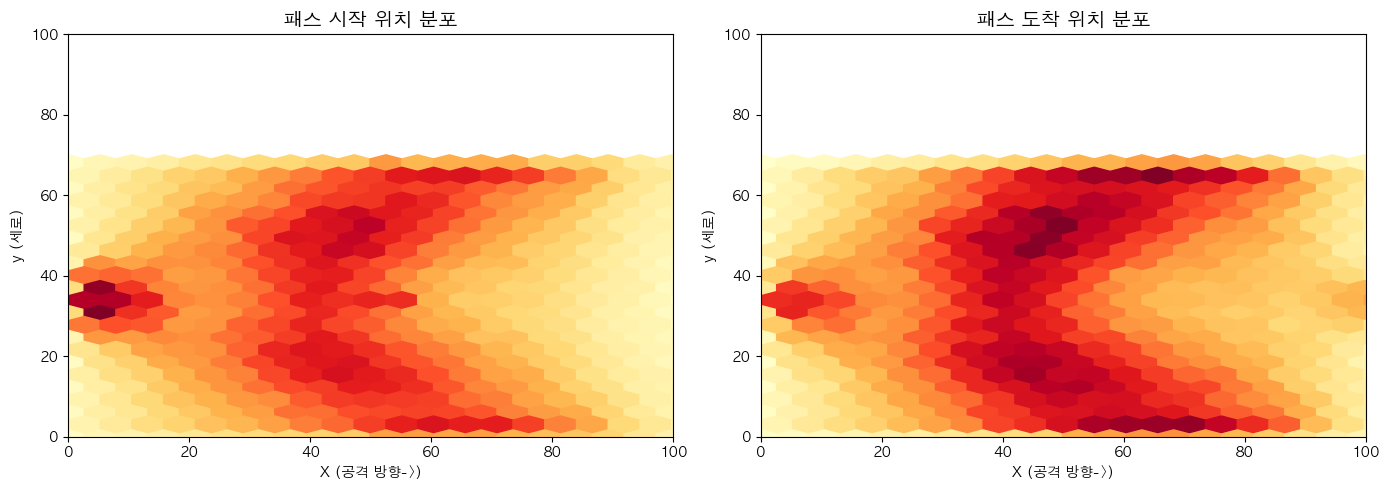


 [인사이트 1]패스는 주로 중앙~왼쪽 지역에서 시작해서 전방으로 전개됩니다.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("k-league 패스 데이터 인사이트 분석")

# 인사이트1: 경기장 구역별 패스 빈도 히트맵
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#패스 시작 위치 히트맵
axes[0].hexbin(train_df['start_x'], train_df['start_y'], 
               gridsize=20, cmap='YlOrRd', mincnt=1)
axes[0].set_title('패스 시작 위치 분포', fontsize=14)
axes[0].set_xlabel('X (공격 방향->)')
axes[0].set_ylabel('y (세로)')
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 100)

#패스 도착 위치 히트맵
axes[1].hexbin(train_df['end_x'], train_df['end_y'], 
               gridsize=20, cmap='YlOrRd', mincnt=1)
axes[1].set_title('패스 도착 위치 분포', fontsize=14)
axes[1].set_xlabel('X (공격 방향->)')
axes[1].set_ylabel('y (세로)')
axes[1].set_xlim(0, 100)
axes[1].set_ylim(0, 100)
plt.tight_layout()
plt.show()

print("\n [인사이트 1]패스는 주로 중앙~왼쪽 지역에서 시작해서 전방으로 전개됩니다.")


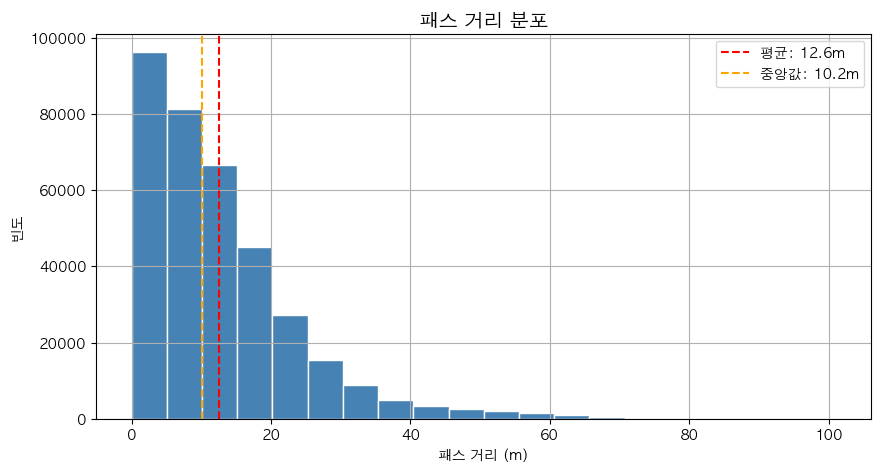


 [인사이트 2] 평균 패스 거리는 약 12.6m 입니다.
  -> 숏패스(15m 이하)가 전체의 68.0% 입니다.


In [ ]:
#인사이트 2: 패스 거리 분포
train_df['pass_distance'] = np.sqrt(
    (train_df['end_x'] - train_df['start_x'])**2 +
    (train_df['end_y'] - train_df['start_y'])**2
)

fig, ax = plt.subplots(figsize=(10, 5))
train_df['pass_distance'].hist(bins=20, color='steelblue', edgecolor='white', ax=ax)
ax.axvline(train_df['pass_distance'].mean(), color='red', linestyle='--',
           label=f"평균: {train_df['pass_distance'].mean():.1f}m")          
ax.axvline(train_df['pass_distance'].median(), color='orange', linestyle='--',
           label=f"중앙값: {train_df['pass_distance'].median():.1f}m")
          
ax.set_title('패스 거리 분포', fontsize=14)
ax.set_xlabel('패스 거리 (m)')
ax.set_ylabel('빈도')
ax.legend()
plt.show()

print(f"\n [인사이트 2] 평균 패스 거리는 약 {train_df['pass_distance'].mean():.1f}m 입니다.")
print(f"  -> 숏패스(15m 이하)가 전체의 {(train_df['pass_distance'] < 15).mean()*100:.1f}% 입니다.")

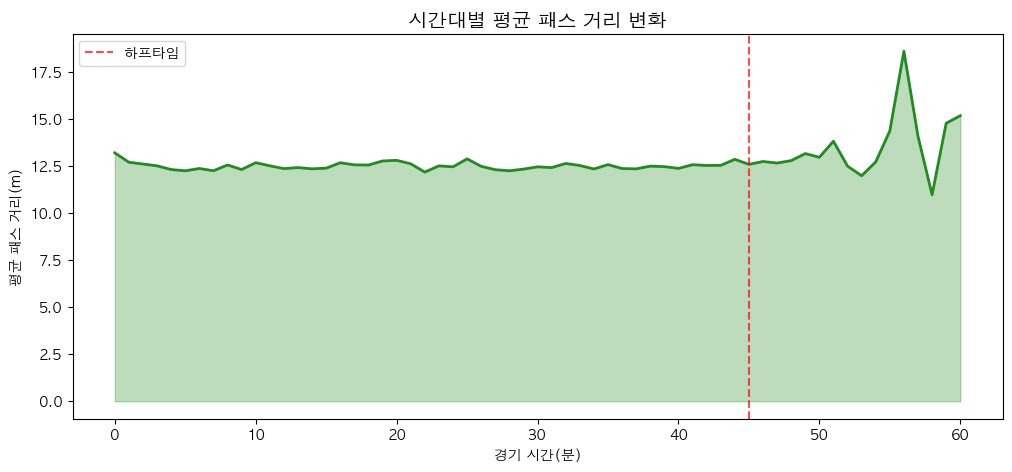


 [인사이트 3] 경기 시간이 지날 수록 패스 거리가 변합니다.
  -> 전반/후반 초반에는 길게, 막판에는 짧아지는 경향 (피로 누적)


In [ ]:
#인사이트 3: 시간대별 패스 패턴 변화
train_df['minute'] = train_df['time_seconds'] // 60

minute_stats = train_df.groupby('minute')['pass_distance'].mean().reset_index()

fig, ax= plt.subplots(figsize=(12, 5))
ax.plot(minute_stats['minute'], minute_stats['pass_distance'],
        color='forestgreen', linewidth=2)
ax.axvline(45, color='red', linestyle='--', alpha=0.7, label='하프타임')
ax.fill_between(minute_stats['minute'], minute_stats['pass_distance'], alpha=0.3, color='forestgreen')
ax.set_title('시간대별 평균 패스 거리 변화', fontsize=14)
ax.set_xlabel('경기 시간(분)')
ax.set_ylabel('평균 패스 거리(m)')
ax.legend()
plt.show()

print("\n [인사이트 3] 경기 시간이 지날 수록 패스 거리가 변합니다.")
print("  -> 전반/후반 초반에는 길게, 막판에는 짧아지는 경향 (피로 누적)")

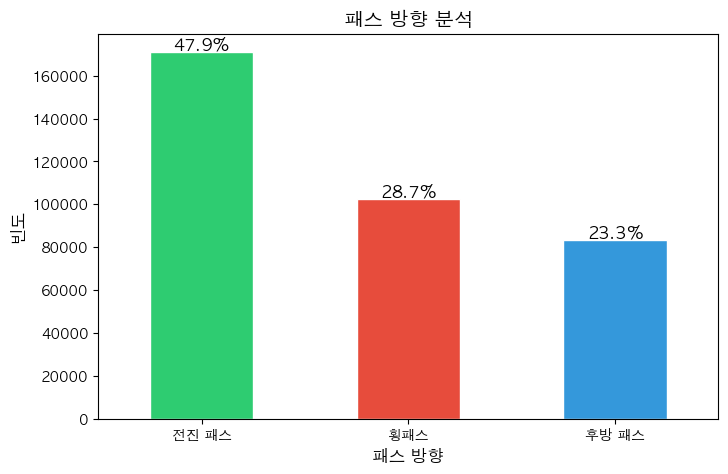


 [인사이트 4] 전진 패스가 47.9%로 가장 많습니다.
   -> k리그는 공격적인 축구 스타일을 선호합니다.


In [ ]:
#인사이트 4: 패스 방향 분석(전진, 후방, 횡패스)
threshold = 2.0
diff_x = train_df['end_x'] - train_df['start_x']

train_df['pass_direction'] = np.where(
    diff_x > threshold, '전진 패스',
    np.where(diff_x < -threshold, '후방 패스', '횡패스')
)
direction_counts = train_df['pass_direction'].value_counts()

fig, ax= plt.subplots(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c', '#3498db']
direction_counts.plot(kind='bar', color=colors, edgecolor='white', ax=ax)
ax.set_title('패스 방향 분석', fontsize=14)
ax.set_xlabel('패스 방향', fontsize=12)
ax.set_ylabel('빈도', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

for i, v in enumerate(direction_counts):
    ax.text(i, v +1000, f'{v/len(train_df)*100:.1f}%', ha='center', fontsize=12)

plt.show()
print(f"\n [인사이트 4] 전진 패스가 {direction_counts['전진 패스']/len(train_df)*100:.1f}%로 가장 많습니다.")
print("   -> k리그는 공격적인 축구 스타일을 선호합니다.")

모델이 가장 중요하게 본 변수 Top 5


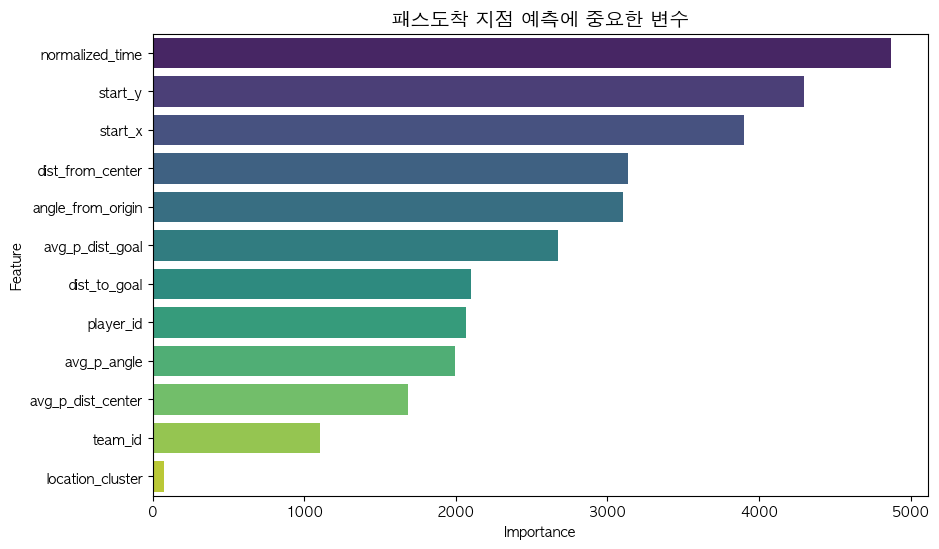


 [인사이트 5] 중요 변수 해석:
   normalized_time: 4867
   start_y: 4296
   start_x: 3903


In [ ]:
#인사이트 5: feature immportance(모델이 중요하게 본 변수)
print("모델이 가장 중요하게 본 변수 Top 5")

#LightGBM 모델에서 feature immportance를 추출
feature_importance = model_lgbm.estimators_[0].feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis', ax=ax)
ax.set_title('패스도착 지점 예측에 중요한 변수', fontsize=14)
plt.show()

print("\n [인사이트 5] 중요 변수 해석:")

for i, row in importance_df.head(3).iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.0f}")


In [45]:
"""
1. TOP 1: normalized_time (경기 시간)
[해석] "축구는 결국 시간과의 싸움이다."
왜 1등일까요? 전반 5분과 전반 40분의 패스는 질적으로 다릅니다. 경기 초반에는 정교한 빌드업을 하지만, 시간이 지날수록 체력이 떨어지거나 급해지면서 패스의 도착 지점이 완전히 달라진다는 뜻입니다.
깊은 인사이트: AI는 "몇 분에 패스를 하느냐"를 보고 그 팀의 '조급함'이나 '피로도'를 읽어냅니다. 후반 막판에 나오는 패스 좌표는 논리적인 전술보다 본능적인 롱볼(Long Ball)일 확률이 높다는 것을 AI가 간파한 것이죠.

2. TOP 2 & 3: start_y, start_x (시작 위치)
[해석] "공간이 운명을 결정한다."
왜 상위권일까요? 이건 물리적인 법칙입니다. 하프라인 뒤에서 패스를 시작하면 도착 지점은 보통 전방이겠지만 코너 플래그 근처라면 골대로 향하겠죠.
깊은 인사이트: 이 두 변수가 상위권이라는 건, 우리 모델이 축구의 '공간적 제약'을 아주 잘 학습했다는 증거입니다. 단순히 운에 맡기는 게 아니라, "여기서 찼으면 저기쯤 떨어지겠군"이라는 물리적 예측을 탄탄하게 하고 있다는 뜻입니다.

3. TOP 4 & 5: dist_from_center, angle_from_origin (기하학적 변수)
[해석] "중앙인가 측면인가, 이것이 문제로다.
"왜 중요할까요? 중앙 미드필더가 뿌리는 패스와 윙어가 올리는 크로스는 각도(Angle) 자체가 다릅니다.
깊은 인사이트: 이 변수들은 모델에게 '전술적 시야'를 제공합니다. 중앙에 있으면 360도 어디로든 갈 수 있지만, 사이드 라인에 붙어 있으면 패스 각도가 제한되죠. AI는 이 '각도'를 통해 현재 선수가 '윙어인지 미드필더인지'를 스스로 판단하고 있습니다.

4. 주목할 점: player_id와 team_id
아이러니하게도 선수 이름(player_id)보다 '시간'이나 '위치'가 훨씬 중요하게 나옵니다.
진짜 깊은 인사이트: "K리그 패스는 선수의 개인 기량(Style)보다는 전술적인 위치(System)와 상황(Time)에 더 크게 의존한다"는 가설을 세워볼 수 있습니다. 즉, 어떤 선수가 그 자리에 있든 간에 그 시간대, 그 위치에서는 비슷한 곳으로 패스를 보내는 경향이 강하다는 흥미로운 결론에 도달하게 됩니다.

최종결론
"k_league는 선수 개인의 취향보다 경기 시간과 위치에 따른 전술적 패턴이 아주 뚜렷합니다. 특히 후반전 시간이 흐를수록 패스가 어디로 튈지 모델이 가장 민감하게 반응하고 있으니, 체력 관리가 승패의 핵심이겠네요!"

_IncompleteInputError: incomplete input (1497684756.py, line 1)